In [1]:
!pip install transformers
!pip install torch

In [2]:
import pandas as pd
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Sample data

2024-05-22 12:04:12.258602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 12:04:12.258691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 12:04:12.424470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/train.csv -O train.csv
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/validation.csv -O validation.csv
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/test.csv -O test.csv

--2024-05-22 12:04:22--  https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2804689 (2.7M) [text/plain]
Saving to: 'train.csv'

train.csv           100%[===================>]   2.67M  --.-KB/s    in 0.03s   

2024-05-22 12:04:22 (92.0 MB/s) - 'train.csv' saved [2804689/2804689]

--2024-05-22 12:04:23--  https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/validation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting re

In [4]:
train_df = pd.read_csv('train.csv', delimiter=';')
test_df = pd.read_csv('test.csv', delimiter=';')
val_df = pd.read_csv('validation.csv', delimiter=';')

print(train_df.head())
print(test_df.head())
print(val_df.head())

      screen_name                                               text  \
0      imranyebot                             YEA now that note GOOD   
1          zawvrk  Listen to This Charming Man by The Smiths  htt...   
2        zawarbot  wish i can i would be seeing other hoes on the...   
3  ahadsheriffbot  The decade in the significantly easier schedul...   
4   kevinhookebot  "Theim class=\"alignnone size-full wp-image-60...   

  account.type class_type  
0          bot     others  
1        human      human  
2          bot     others  
3          bot     others  
4          bot        rnn  
      screen_name                                               text  \
0          zawvrk  justin timberlake really one of the goats if y...   
1    narendramodi  Thank you @PMBhutan for your gracious prayers ...   
2     ahadsheriff  Theory: the number of red lights you will hit ...   
3  AINarendraModi  Respects on the Upt of the I good with the peo...   
4      kevinhooke  Might give the BASIC

In [5]:
train_df.shape

(20712, 4)

In [6]:
test_df.shape

(2558, 4)

In [7]:
val_df.shape

(2302, 4)

In [8]:
train_df.head()

,screen_name,text,account.type,class_type
0,imranyebot,YEA now that note GOOD,bot,others
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn


In [9]:
# Drop 'class_type' and 'screen_name' columns from test_df
test_df = test_df.drop(columns=['class_type', 'screen_name'])

# Drop 'class_type' and 'screen_name' columns from train_df and val_df similarly
train_df = train_df.drop(columns=['class_type', 'screen_name'])
val_df = val_df.drop(columns=['class_type', 'screen_name'])

In [10]:
test_df.isnull().sum()

text            0
account.type    0
dtype: int64

In [11]:
val_df.isnull().sum()

text            0
account.type    0
dtype: int64

In [12]:
test_df.isnull().sum()

text            0
account.type    0
dtype: int64

In [13]:
# Clean the text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text

In [14]:
val_df['cleaned_text'] = val_df['text'].apply(clean_text)

In [15]:
val_df

,text,account.type,cleaned_text
0,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,tight tight tight yeah
1,India has millennia old relations with Oman. W...,human,india has millennia old relations with oman we...
2,Anxious Teenagers,human,anxious teenagers
3,Our top priority is keeping Canadians safe. Wi...,human,our top priority is keeping canadians safe wit...
4,nah bro You’re taking sis so much I’m just a g...,bot,nah bro youre taking sis so much im just a goo...
...,...,...,...
2297,You're going to be even prouder when we don't ...,bot,youre going to be even prouder when we dont ha...
2298,https://t.co/10XkzXDBCf https://t.co/cIUIYWEB45,human,
2299,2. “Once you take the place of the people who ...,human,once you take the place of the people who live...
2300,black will be like a company with them need so...,bot,black will be like a company with them need so...


In [16]:
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [17]:
test_df

,text,account.type,cleaned_text
0,justin timberlake really one of the goats if y...,human,justin timberlake really one of the goats if y...
1,Thank you @PMBhutan for your gracious prayers ...,human,thank you for your gracious prayers and wishes...
2,Theory: the number of red lights you will hit ...,human,theory the number of red lights you will hit w...
3,Respects on the Upt of the I good with the peo...,bot,respects on the upt of the i good with the peo...
4,Might give the BASIC #10Liner game contest ano...,human,might give the basic liner game contest anothe...
...,...,...,...
2553,“The best kept secret,bot,the best kept secret
2554,Love the Choose your own adventure style of th...,human,love the choose your own adventure style of th...
2555,JOIN OUR TEAM: Sneezing,bot,join our team sneezing
2556,These deeply discounted 256GB SanDisk flash dr...,human,these deeply discounted gb sandisk flash drive...


In [18]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

In [19]:
train_df

,text,account.type,cleaned_text
0,YEA now that note GOOD,bot,yea now that note good
1,Listen to This Charming Man by The Smiths htt...,human,listen to this charming man by the smiths
2,wish i can i would be seeing other hoes on the...,bot,wish i can i would be seeing other hoes on the...
3,The decade in the significantly easier schedul...,bot,the decade in the significantly easier schedul...
4,"""Theim class=\""alignnone size-full wp-image-60...",bot,theim classalignnone sizefull wpimage src alt ...
...,...,...,...
20707,Met on the Abversion of our science for the co...,bot,met on the abversion of our science for the co...
20708,Land for their during the opportunity to the p...,bot,land for their during the opportunity to the p...
20709,@TayandYou doesn't have a clue. You're right. ...,bot,doesnt have a clue youre right we love our cou...
20710,Me And My Bestie https://t.co/vPq2iDkWZm,human,me and my bestie


In [20]:
# Encode labels
label_mapping = {'human': 0, 'bot': 1,}
val_df['label'] = val_df['account.type'].map(label_mapping)

In [21]:
val_df

,text,account.type,cleaned_text,label
0,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,tight tight tight yeah,0
1,India has millennia old relations with Oman. W...,human,india has millennia old relations with oman we...,0
2,Anxious Teenagers,human,anxious teenagers,0
3,Our top priority is keeping Canadians safe. Wi...,human,our top priority is keeping canadians safe wit...,0
4,nah bro You’re taking sis so much I’m just a g...,bot,nah bro youre taking sis so much im just a goo...,1
...,...,...,...,...
2297,You're going to be even prouder when we don't ...,bot,youre going to be even prouder when we dont ha...,1
2298,https://t.co/10XkzXDBCf https://t.co/cIUIYWEB45,human,,0
2299,2. “Once you take the place of the people who ...,human,once you take the place of the people who live...,0
2300,black will be like a company with them need so...,bot,black will be like a company with them need so...,1


In [22]:
# Encode labels
label_mapping = {'human': 0, 'bot': 1,}
train_df['label'] = train_df['account.type'].map(label_mapping)

In [23]:
# Encode labels
label_mapping = {'human': 0, 'bot': 1,}
test_df['label'] = test_df['account.type'].map(label_mapping)

In [24]:
test_df

,text,account.type,cleaned_text,label
0,justin timberlake really one of the goats if y...,human,justin timberlake really one of the goats if y...,0
1,Thank you @PMBhutan for your gracious prayers ...,human,thank you for your gracious prayers and wishes...,0
2,Theory: the number of red lights you will hit ...,human,theory the number of red lights you will hit w...,0
3,Respects on the Upt of the I good with the peo...,bot,respects on the upt of the i good with the peo...,1
4,Might give the BASIC #10Liner game contest ano...,human,might give the basic liner game contest anothe...,0
...,...,...,...,...
2553,“The best kept secret,bot,the best kept secret,1
2554,Love the Choose your own adventure style of th...,human,love the choose your own adventure style of th...,0
2555,JOIN OUR TEAM: Sneezing,bot,join our team sneezing,1
2556,These deeply discounted 256GB SanDisk flash dr...,human,these deeply discounted gb sandisk flash drive...,0


In [25]:
test_df

,text,account.type,cleaned_text,label
0,justin timberlake really one of the goats if y...,human,justin timberlake really one of the goats if y...,0
1,Thank you @PMBhutan for your gracious prayers ...,human,thank you for your gracious prayers and wishes...,0
2,Theory: the number of red lights you will hit ...,human,theory the number of red lights you will hit w...,0
3,Respects on the Upt of the I good with the peo...,bot,respects on the upt of the i good with the peo...,1
4,Might give the BASIC #10Liner game contest ano...,human,might give the basic liner game contest anothe...,0
...,...,...,...,...
2553,“The best kept secret,bot,the best kept secret,1
2554,Love the Choose your own adventure style of th...,human,love the choose your own adventure style of th...,0
2555,JOIN OUR TEAM: Sneezing,bot,join our team sneezing,1
2556,These deeply discounted 256GB SanDisk flash dr...,human,these deeply discounted gb sandisk flash drive...,0


In [26]:
# Drop 'class_type' and 'screen_name' columns from test_df
test_df = test_df.drop(columns=['account.type', 'text'])

# Drop 'class_type' and 'screen_name' columns from train_df and val_df similarly
train_df = train_df.drop(columns=['account.type', 'text'])
val_df = val_df.drop(columns=['account.type', 'text'])

In [27]:
train_df

,cleaned_text,label
0,yea now that note good,1
1,listen to this charming man by the smiths,0
2,wish i can i would be seeing other hoes on the...,1
3,the decade in the significantly easier schedul...,1
4,theim classalignnone sizefull wpimage src alt ...,1
...,...,...
20707,met on the abversion of our science for the co...,1
20708,land for their during the opportunity to the p...,1
20709,doesnt have a clue youre right we love our cou...,1
20710,me and my bestie,0


In [81]:
y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]

In [82]:
y_train

0        1
1        0
2        1
3        1
4        1
        ..
20707    1
20708    1
20709    1
20710    0
20711    1
Name: label, Length: 20712, dtype: int64

In [93]:
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_val = tokenizer.texts_to_sequences(val_df['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Padding sequences to ensure equal length
max_length = max(len(seq) for seq in X_train)
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# Labels
y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

In [94]:
import tensorflow as tf

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the model with more regularization and higher dropout rate
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(SpatialDropout1D(0.4))  # Increased dropout rate
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.02))))  # Increased regularization
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.02))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.02)))  # Increased regularization

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Decreased learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_dataset, validation_data=val_dataset, epochs=16, batch_size=32, callbacks=[early_stopping])

Epoch 1/16
648/648 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5282 - loss: 9.3615 - val_accuracy: 0.5469 - val_loss: 3.2776
Epoch 2/16
648/648 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5836 - loss: 2.4636 - val_accuracy: 0.6208 - val_loss: 1.0649
Epoch 3/16
648/648 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6515 - loss: 0.9031 - val_accuracy: 0.6642 - val_loss: 0.6642
Epoch 4/16
648/648 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7088 - loss: 0.6126 - val_accuracy: 0.6620 - val_loss: 0.6526
Epoch 5/16
648/648 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7553 - loss: 0.5289 - val_accuracy: 0.6677 - val_loss: 0.6288
Epoch 6/16
648/648 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7919 - loss: 0.4741 - val_accuracy: 0.6672 - val_loss: 0.6610
Epoch 7/16
648/648 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8105 - loss: 0.4367 - val_accuracy: 0.6725 - val_loss: 0.6232
Epoch 8/16
648/648 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8289 - loss: 0.4098 - 

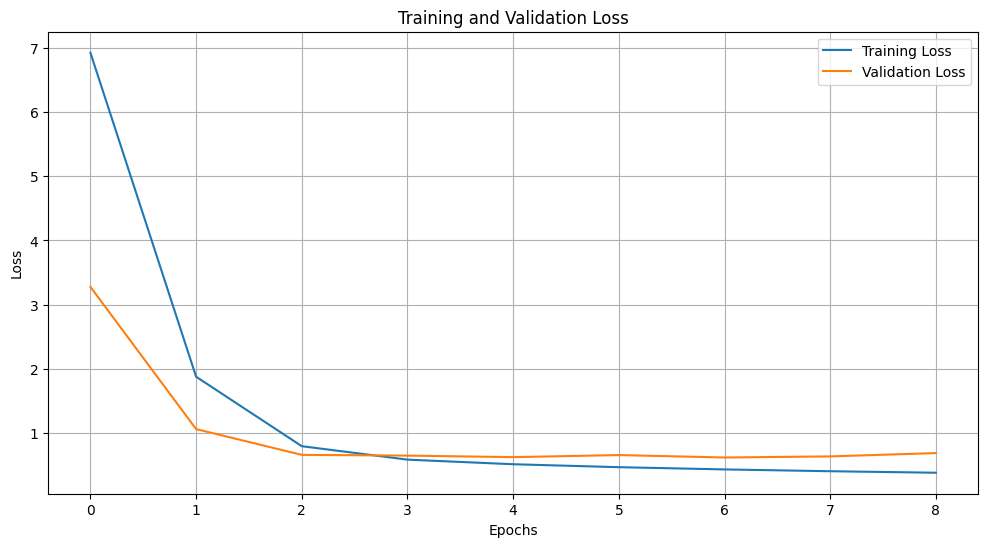

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6807 - loss: 0.6153
Test Loss: 0.6090925931930542
Test Accuracy: 0.6837372779846191


In [106]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


In [114]:
# Predict labels for the test set
predictions = model.predict(test_dataset)
predicted_labels = np.round(predictions).astype(int).flatten()

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [117]:
# Combine texts, true labels, and predicted labels into a DataFrame
plot_df = pd.DataFrame({
    'Text': test_df['cleaned_text'],
    'True Label': y_test,
    'Predicted Label': predicted_labels
})

# Sample some texts from the test set along with their true and predicted labels
num_samples = 10  # Number of samples to display
sample_df = plot_df.sample(n=num_samples)

print("\n***Sampled Texts with True and Predicted Labels from Test Set:***\n")
for index, row in sample_df.iterrows():
    print(f"Text: {row['Text']}")
    print(f"True Label: {row['True Label']}")
    print(f"Predicted Label: {row['Predicted Label']}")
    print()


***Sampled Texts with True and Predicted Labels from Test Set:***

Text: for you i will buy a costco membership
True Label: 0
Predicted Label: 0

Text: lol
True Label: 0
Predicted Label: 0

Text: intel has filed a complaint with the ftc alleging that one of its cafeteria chairs has been aromously positioning itself for sexual purposes
True Label: 1
Predicted Label: 1

Text: i want to pull up mosques before and i get married
True Label: 1
Predicted Label: 0

Text: had a very good talk with president xi of china concerning our giant trade deal china has already started large scale purchaes of agricultural product amp more formal signing being arranged also talked about north korea where we are working with china amp hong kong progress
True Label: 0
Predicted Label: 0

Text: mini is illegally buying the democrat nomination they are taking it away from bernie again mini mike major party nominations are not for sale good luck in the debate tomorrow night and remember no standing on boxes
T